## Design of experiment

In [1]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

import numpy as np
import pandas as pd

from fixed_bed_model_indexed_dynamic import *
#from Users.wangjialu.pyomo.pyomo.contrib.doe import fim_doe
from idaes.apps.uncertainty_propagation.sens import get_dsdp
import time

alpha option:
1 / (1 + exp(-x))
    Import ComponentSet from pyomo.common.collections.  (deprecated in 5.7.1)
    (called from <frozen importlib._bootstrap>:228)
    'pyomo.common.sorting.sorted_robust'.  Please update your import.
    (deprecated in 6.1) (called from <frozen importlib._bootstrap>:228)


### Load experimental data

In [2]:
def load_data(data_name="co2_breakthrough.csv", no_time=68, len_time=3200, source="computer", self_defined=True):
    '''Loading experimental data 
    Arg: 
        data_name: the file name of the data. If it's lab experimental data from LNBL, use the default name. Otherwise,
                   put the new filenames on it
        source: lab or computer
        self_defined: a choice for lab experimental data. If true, use self-defined timepoints [0,3200], 69 timepoints.
                      if false, use the timepoints of experimental data [-10, 3208], 68
    Return:
    
    '''
    
    
    if (source=="lab"):
        # Import experimental data
        exp = pd.read_csv(data_name)
        
        # exp_time_st is a numpy array, containing every timepoint in experimental data in [s]
        exp_time_st = exp.time.to_numpy()*60

        # exp_yCO2_st is a dictionary, keys are timepoints in [s], values are the yCO2
        exp_yCO2_st = {}
        for i in range(len(exp_time_st)):    
            exp_yCO2_st[exp_time_st[i]] = exp.yCO2[i]

        # exp_yCO2_st is a dictionary, keys are timepoints in [s], values are the FCO2
        exp_FCO2_st = {}
        for i in range(len(exp_time_st)):    
            exp_FCO2_st[exp_time_st[i]] = exp.FCO2[i]

        if self_defined:
            # a list of timepoints for creating the model
            time_exp = time_points(no_time, len_time)

            # Experimental data of yCO2 value at outlet. For specifying objective function
            exp_yCO2 = {}
            exp_yCO2_re = np.interp(time_exp, exp_time_st, exp.yCO2)
            for i in range(len(time_exp)):    
                exp_yCO2[time_exp[i]] = exp_yCO2_re[i]

            # Experimental data of yCO2 value at outlet. For specifying objective function
            exp_FCO2 = {}
            exp_FCO2_re = np.interp(time_exp, exp_time_st, exp.FCO2)
            for i in range(len(time_exp)):    
                exp_FCO2[time_exp[i]] = exp_FCO2_re[i]
            
            return time_exp, exp_yCO2
            
        else: 
            #exp_time = exp.time*60
            return exp_time_st, exp_yCO2_st
            
    elif (source=="computer"):
        
        time_exp = time_points(no_time, len_time)
        
        sol = pd.read_csv(data_name)
    
        yco2_exp = {}
        temp_mid_exp = {}
        temp_end_exp = {}

        for i in range(len(time_exp)):    
            yco2_exp[time_exp[i]] = sol['FCO2'][i]
            temp_mid_exp[time_exp[i]] = sol['temp_mid'][i]
            temp_end_exp[time_exp[i]] = sol['temp_end'][i]

        return yco2_exp, temp_mid_exp, temp_end_exp
        

### Define objective function

In [3]:
def ObjRule(m, t_mid=False, t_end=False):
    objfunc = 0
    T=[]
    for t in m.t:
        T.append(value(t))
        
    #var_fco2 = 2.3697116742123714E-7
    var_fco2 = 1.077255E-07
    #var_midT = 9.1369
    var_midT = 8.5945
    #var_endT = 9.1284
    var_endT = 8.5945
    
    #objfunc += sum((m.FCO2['base',19,t]/m.FCO2['base',19,T[-1]] - m.yCO2[t]/m.yCO2[T[-1]])**2 for t in m.t) 
    #objfunc +=  sum(((m.FCO2['base',19,t] - m.yCO2[t])**2)*1.0E5/2.3697116742123714 for t in m.t)
    objfunc += sum(((m.FCO2['base',19,t] - m.yCO2[t])**2)*1.0E5/1.077255E-07 for t in m.t)
    
    if t_mid:
    #    objfunc += sum((m.temp['base',10,t]/m.temp['base',10,T[-1]] - m.midT[t]/m.midT[T[-1]])**2 for t in m.t) 
        objfunc += sum(((m.temp['base',10,t] - m.midT[t])**2)*0.01/8.5945 for t in m.t)
        
    if t_end:
    #    objfunc += sum((m.temp['base',19,t]/m.temp['base',19,T[-1]] - m.endT[t]/m.endT[T[-1]])**2 for t in m.t) 
        objfunc += sum(((m.temp['base',19,t] - m.endT[t])**2)*0.01/8.5945 for t in m.t)     
        
    return objfunc

In [4]:
def add_obj(doe, NFEt, time_scale, file=None, source_opt="computer", self_def=True):
    '''Fit for self defined timepoints 
    '''
    if (source_opt=="computer"):
        exp_yco2, exp_temp_mid, exp_temp_end = load_data(data_name=file,no_time=NFEt, len_time=time_scale, source="computer")
        
        doe.yCO2 = Param(doe.t, initialize=exp_yco2)
        doe.midT = Param(doe.t, initialize=exp_temp_mid)
        doe.endT = Param(doe.t, initialize=exp_temp_end)
        doe.obj = Objective(rule=ObjRule, sense=minimize)
        
    elif (source_opt=="lab"):
        exp_time_re, exp_yco2 = load_data(no_time=NFEt, len_time=time_scale, source="lab", self_defined=self_def)
        
        doe.yCO2 = Param(doe.t, initialize=exp_yco2)
        doe.obj = Objective(rule=ObjRule, sense=minimize)
    
    

## Solve the model 

In [5]:
def add_model(doe, timepoints, time_start=0):
    '''
    add variables, equations and discretize the model time
    Argument:
        timepoints: the timesteps
        time_start: where the timesteps start. For self defined timepoints it's 0. For experimental data it's -10.
    '''
    add_variables(doe, timesteps=timepoints, start=time_start)
    
    add_equations(doe)
    
    print ('the number of timepoints is', NFEt)
    
def discretize(doe, no_points=68):
    '''
    no_points: how many time invertals to divide. For self defined timepoints it's 69. For experimental data it's 68. 
    here it's 68
    '''
    if collo:
        TransformationFactory('dae.collocation').apply_to(doe, nfe=no_points, ncp=3, scheme='LAGRANGE-RADAU', wrt=doe.t)
    else:
        TransformationFactory('dae.finite_difference').apply_to(doe, nfe=no_points, scheme='BACKWARD', wrt=doe.t)
    
    
def initialize(doe, init_point):
    '''
    Argument: 
        init_point: initial point, csv file
    '''
    # Initialize 
    print('The init point is', init_point)    
    store = pd.read_csv(init_point)
    position_max = store['position'].max()
    store['position'] = store['position'] / position_max

    initial_bed_csv(doe, store)
    fix_initial_bed(doe)
    
    
def solve_model(doe):
    # Define a solver
    solver = custom_ipopt()
    solver.options['tol'] = 1E-8
    solver.options['max_iter'] = 3000
    solver.options['halt_on_ampl_error'] = 'yes'
    #solver.options['bound_push'] = 1E-2
    
    #solver.options['ma27_meminc_factor'] = 3
    #if pert==1:
    #    solver.options['output_file'] = 'outputT%.0fy%.0f.txt'%(T, y*100)
    #else:
    #    solver.options['output_file'] = 'output_upperT%.0fy%.0f.txt'%(T, y*100)
    solver.options['print_level'] = 5
    results = solver.solve(doe, tee=True, symbolic_solver_labels=True)
    #doe.load(results)
    #if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.infeasible):
    #    print('well converged')
    #solver.solve(doe, tee=True)
    return results

## Square problem

In [8]:
NFEt = 68
time_scale = 3200
collo = False
exp_time = time_points(NFEt, time_scale)

scena_all = {'scena-name': [0], 'fitted_transport_coefficient':212, 'ua': np.log(5.0E6)}

#init_point = '/Users/wangjialu/dowlinglab/sorption-fixed-bed/20200729_energy.csv'
#init_point = '20210916_feed313_bath293.csv'
#init_point = '/Users/wangjialu/dowlinglab/sorption-fixed-bed/fixed_bed_initial/T353y20_5e3.csv'
init_point = '20210916_feed293_bath313_5e4.csv'
#init_point = 'init_test.csv'
#init_point = 'T353y20_5e3.csv'

doe_model_opt = True
k_aug_opt=False

In [9]:
test = create_model(scena_all, temp_feed=313.15, temp_bath=313.15, y=0.15, doe_model=doe_model_opt, k_aug=k_aug_opt, opt=False, diff=0)
add_model(test, exp_time)
#add_obj(test, NFEt, time_scale, file='353_20_5e3_exp.csv', source_opt="computer")
#fix_initial_bed(test)
#initial_sim(test)
#simulator(test)

initialize(test, init_point)
discretize(test, no_points=NFEt)

test.temp_feed.fix()
test.temp_bath.fix()
test.yfeed.fix()

if (doe_model_opt and not k_aug_opt):
    result_ = solve_model(test)
    
else:
    test.fitted_transport_coefficient.setub(scena_all['fitted_transport_coefficient'])
    test.fitted_transport_coefficient.setlb(scena_all['fitted_transport_coefficient'])
    test.ua.setub(scena_all['ua'])
    test.ua.setlb(scena_all['ua'])

    var_name = ['fitted_transport_coefficient[0]', 'ua[0]']
    var_dict = {'fitted_transport_coefficient[0]':212, 'ua[0]': np.log(5.0E6)}
    
    time0 = time.time()
    dsdp_re, col = get_dsdp(test, var_name, var_dict, tee=True)
    time1 = time.time()
    print('Total time:', time1-time0)

The inlet feed density is 38.40726649935368 [mol/m3]
the number of timepoints is 68
The init point is 20210916_feed293_bath313_5e4.csv
Model # of time grid is 69 , initial point # of time grid is 69
wangjialudeMacBook-Pro.local
Loading custom Ipopt...
Ipopt 3.13.3: linear_solver=ma57
tol=1e-08
max_iter=3000
halt_on_ampl_error=yes
print_level=5


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    93745
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    51003

Total num


Number of Iterations....: 122

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   6.9428373156040508e-09    6.9428373156040508e-09
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   6.9428373156040508e-09    6.9428373156040508e-09


Number of objective function evaluations             = 128
Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            = 128
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 124
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 122
Total CPU secs in IPOPT (w/o function evaluations)   =     59.763
Total CPU secs in NLP function evalua

In [19]:
print(value(test.FCO2[0, 0, 0]))

0.000199428298248


In [ ]:
print(dsdp_re.toarray().T)

In [36]:
def breakthrough_modify2(m, file=None, source="lab"):
    '''
    Draw breakthrough curve of the Pyomo model
    
    Arguments:
        m: Pyomo model
        file: when source = 'computer', this is where the computer experimental data is stored. Otherwise, its default is None
        source: if computer, it is plotting the computer experiment data. If lab, its comparing the experiments from the lab
    
    Return: None 
    
    Other: plot
    
    '''
    
    
    # unit: mol/m3
    outlet_den, _, _, _ = extract3d(m, m.C, 'CO2')
    
    # unit: cm/s
    outlet_vel, _, _, _ = extract2d(m, m.v)
    
    outlet_n2, _, _, _ = extract3d(m, m.C, 'N2')
    
    model_temp, _,_,_ = extract2d(m,m.temp)
    
    
    T = []
    for j in m.t:
        T.append(value(j))
        t_final = T[-1]
        
    
    if source == "lab":
        break_wvu = pd.read_csv('/Users/wangjialu/dowlinglab/sorption-fixed-bed/breakthrough_wvu.csv')
    
        exp = pd.read_csv('/Users/wangjialu/dowlinglab/sorption-fixed-bed/co2_breakthrough.csv')
        
        data_c1 = exp['FCO2']
        data_c = np.asarray(data_c1)
        data_t1 = exp['time']  
        data_t = np.asarray(data_t1*60+10)
        new_data = np.interp(T, data_t, data_c)
    
        fco2 = []
        for t in m.t:
            fco2.append(value(m.FCO2[0,19,t]))
        
        yco2 = []
        for i in range(len(fco2)):
            yco2.append(fco2[i]/fco2[-1])
            
        # real value of FCO2. for verification
        comp = outlet_den[-1,:]*outlet_vel[-1,:]/(outlet_den[-1, -1]*outlet_vel[-1,-1])
    
        plt.plot(exp['time']*60, exp['FCO2'],'b.', color='r', label='Experimental data')
        #plt.plot(T, outlet_den[-1,:]*outlet_vel[-1,:]/(outlet_den[-1, -1]*outlet_vel[-1,-1]), label='Model prediction')
        plt.plot(T, yco2, label='Model prediction')
        
        plt.xlabel('time [s]')
        plt.ylabel('Normalized outlet gas density of CO\N{SUBSCRIPT TWO} ')
        plt.title('Breakthrough curve')
        #plt.savefig('break_tr%.fua%.f.png'%(tr,ua))
        plt.legend()
        plt.show()
        
    elif source == "computer": 
        
        sol = pd.read_csv(file)
    
        #for i in range(len(time_exp)):    
        #    yco2_exp[time_exp[i]] = sol['FCO2'][i]
        #    temp_mid_exp[time_exp[i]] = sol['temp_mid'][i]
        #    temp_end_exp[time_exp[i]] = sol['temp_end'][i]
        
        exp_fco2 = np.asarray(sol['FCO2'].values.tolist())
        exp_temp_mid = np.asarray(sol['temp_mid'].values.tolist())
        exp_temp_end = np.asarray(sol['temp_end'].values.tolist())
        
        plt.plot(T, exp_fco2/exp_fco2[-1], label = 'Experimental data')
        plt.plot(T, outlet_den[-1,:]*outlet_vel[-1,:]/(outlet_den[-1, -1]*outlet_vel[-1,-1]), label='Model prediction')
        plt.xlabel('time [s]')
        plt.ylabel('Normalized outlet gas density of CO\N{SUBSCRIPT TWO} ')
        plt.title('Breakthrough curve')
        #plt.savefig('break_tr%.fua%.f.png'%(tr,ua))
        plt.legend()
        plt.show()
        
        
        plt.plot(T, exp_temp_mid, label='Experimental data of middle T')
        plt.plot(T, model_temp[10,:], label='Model prediction of middle T')
        plt.plot(T, exp_temp_end, label='Experimental data of end T')
        plt.plot(T, model_temp[19,:], label='Model prediction of end T')
        plt.xlabel('time [s]')
        plt.ylabel('Temperature [K]')
        plt.title('Temperature model prediction and experimental data')
        #plt.savefig('break_tr%.fua%.f.png'%(tr,ua))
        plt.legend()
        plt.show()


/var/folders/cn/dbk7vfw51_g_gb8jqhz4j3ph0000gn/T/ipykernel_10026/3584945634.py:56: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b." (-> color='b'). The keyword argument will take precedence.
  plt.plot(exp['time']*60, exp['FCO2'],'b.', color='r', label='Experimental data')


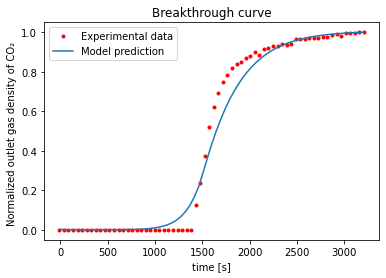

In [37]:
breakthrough_modify2(test)

In [ ]:
def temp_draw(m):
    T, _, _, _ = extract2d(m, m.temp)
    
    T_init = T[0]
    T_mid = T[10]
    T_end = T[19]
    
    plt.plot(exp_time, T_init, label='Inlet end bed T')
    plt.plot(exp_time, T_mid, label='Mid end bed T')
    plt.plot(exp_time, T_end, label='Outlet end bed T')
    plt.xlabel('Time [s]')
    plt.ylabel('Temperature [K]')
    plt.legend()
    print(np.shape(T))
    
temp_draw(test)

In [ ]:
#add_obj(test, NFEt, time_scale, file='333_40_5e3_exp.csv', source_opt="computer")

In [ ]:
T=[]
fco2_model=[]
fco2_exp=[]
temp_mid_model=[]
temp_mid_exp = []
temp_end_model=[]
temp_end_exp=[]
for t in test.t:
    T.append(value(t))
    

for i in T:    
    fco2_model.append(value(test.FCO2[0,19,i])/value(test.FCO2[0,19,T[-1]]))
    fco2_exp.append(test.yCO2[i]/test.yCO2[T[-1]])
    temp_mid_model.append(value(test.temp[0,10,i])/value(test.temp[0,10,T[-1]]) )
    temp_mid_exp.append(test.midT[i]/test.midT[T[-1]])
    temp_end_model.append(value(test.temp[0,19,i])/value(test.temp[0,19,T[-1]]))
    temp_end_exp.append(test.endT[i]/test.endT[T[-1]])
    
x =  sum((value(test.FCO2[0,19,t])/value(test.FCO2[0,19,T[-1]]) - test.yCO2[t]/test.yCO2[T[-1]])**2 for t in test.t)

x2 =  sum((value(test.temp[0,10,t])/value(test.temp[0,10,T[-1]]) - test.midT[t]/test.midT[T[-1]])**2 for t in test.t)

x3 =  sum((value(test.temp[0,19,t])/value(test.temp[0,19,T[-1]]) - test.endT[t]/test.endT[T[-1]])**2 for t in test.t)

print(x)
print(x2)
print(x3)

In [ ]:
x =  sum(((value(test.FCO2[0,19,t]) - test.yCO2[t])**2)/2.3697116742123714E-07 for t in test.t)

x2 =  sum(((value(test.temp[0,10,t]) - test.midT[t])**2)/9.1369 for t in test.t)

x3 =  sum(((value(test.temp[0,19,t]) - test.endT[t])**2)/9.1284 for t in test.t)

print(x)
print(x2)
print(x3)

In [ ]:
plt.plot(T, fco2_model)
plt.plot(T, fco2_exp)
plt.show()

plt.plot(T, temp_mid_model)
plt.plot(T, temp_mid_exp)
plt.show()

plt.plot(T, temp_end_model)
plt.plot(T, temp_end_exp)
plt.show()

In [ ]:
large_residuals_set(test, 1)

In [ ]:
breakthrough_modify2(test,source="lab")

In [ ]:
dataframe = extract3(test, result_)
dataframe.to_csv('20210916_feed293_bath303_5e6.csv')

In [ ]:
def extract3(m,result):
    ''' 
    Extract results from Pyomo model for brute force DoE problem. 
    Compared to extract2: less options kept, add the design variable values 
    
    Arguments:
        m: the model
    
    Return: a single pandas dataframe storing all results
    '''
    nTime = len(m.t)
    nGrid = len(m.zgrid)
    n = nTime*nGrid
    
    ### Variables to be extracted
    
    # Two 3D variables, for COMPS(N2, CO2, He)
    
    FCO2_1, FCO2_2, FCO2_3, FCO2_4 = extract2d(m, m.FCO2)
    
    FCO21 = np.reshape(FCO2_1, n)
    FCO22 = np.reshape(FCO2_2, n)
    FCO23 = np.reshape(FCO2_3, n)
    FCO24 = np.reshape(FCO2_4, n)
    
    C_N2_1, C_N2_2, C_N2_3, C_N2_4 = extract3d(m,m.C,'N2')
    C_CO2_1, C_CO2_2, C_CO2_3, C_CO2_4 = extract3d(m,m.C,'CO2')
    
    C_N21 = np.reshape(C_N2_1, n)
    C_CO21 = np.reshape(C_CO2_1, n)
    
    C_N22 = np.reshape(C_N2_2, n)
    C_CO22 = np.reshape(C_CO2_2, n)
    
    C_N23 = np.reshape(C_N2_3, n)
    C_CO23 = np.reshape(C_CO2_3, n)
    
    C_N24 = np.reshape(C_N2_4, n)
    C_CO24 = np.reshape(C_CO2_4, n)
    
    
    dcdt_N2_1, dcdt_N2_2, dcdt_N2_3, dcdt_N2_4 = extract3d(m,m.dCdt,'N2')
    dcdt_CO2_1, dcdt_CO2_2, dcdt_CO2_3, dcdt_CO2_4 = extract3d(m,m.dCdt,'CO2')
    
    dcdt_N21 = np.reshape(dcdt_N2_1,n)
    dcdt_CO21 = np.reshape(dcdt_CO2_1,n)
    
    dcdt_N22 = np.reshape(dcdt_N2_2,n)
    dcdt_CO22 = np.reshape(dcdt_CO2_2,n)
    
    dcdt_N23 = np.reshape(dcdt_N2_3,n)
    dcdt_CO23 = np.reshape(dcdt_CO2_3,n)
    
    dcdt_N24 = np.reshape(dcdt_N2_4,n)
    dcdt_CO24 = np.reshape(dcdt_CO2_4,n)
    
    # Three 2D variables
    vel_1, vel_2, vel_3, vel_4 = extract2d(m, m.v)
    
    vel1 = np.reshape(vel_1, n)
    vel2 = np.reshape(vel_2,n)
    vel3 = np.reshape(vel_3,n)
    vel4 = np.reshape(vel_4,n)
    
    P_1, P_2, P_3, P_4 = extract2d(m,m.P)
    P1 = np.reshape(P_1,n)
    P2 = np.reshape(P_2, n)
    P3 = np.reshape(P_3, n)
    P4 = np.reshape(P_4, n)
    
    total_den_1, total_den_2, total_den_3, total_den_4 = extract2d(m,m.total_den)
    total_den1 = np.reshape(total_den_1, n)
    total_den2 = np.reshape(total_den_2, n)
    total_den3 = np.reshape(total_den_3, n)
    total_den4 = np.reshape(total_den_4, n)
    
    if m.energy:
        T_1, T_2, T_3, T_4 = extract2d(m,m.temp)
        T1 = np.reshape(T_1, n)
        T2 = np.reshape(T_2, n)
        T3 = np.reshape(T_3, n)
        T4 = np.reshape(T_4, n)
        
        dTdt_1, dTdt_2, dTdt_3, dTdt_4 = extract2d(m,m.dTdt)
        dTdt1 = np.reshape(dTdt_1,n)
        dTdt2 = np.reshape(dTdt_2,n)
        dTdt3 = np.reshape(dTdt_3,n)
        dTdt4 = np.reshape(dTdt_4,n)
        
        nplin_1, nplin_2, nplin_3, nplin_4 = extract2d(m, m.nplin)
        nplin1 = np.reshape(nplin_1, n)
        nplin2 = np.reshape(nplin_2, n)
        nplin3 = np.reshape(nplin_3, n)
        nplin4 = np.reshape(nplin_4, n)
        
    
    # Seven 3D variables, for SCOMPS(CO2)
    spp_1, spp_2, spp_3, spp_4 = extract3d(m, m.spp, 'CO2') 

    spp1 = np.reshape(spp_1,n)
    spp2 = np.reshape(spp_2,n)
    spp3 = np.reshape(spp_3,n)
    spp4 = np.reshape(spp_4,n)

    nchemstar_1, nchemstar_2, nchemstar_3, nchemstar_4 = extract3d(m, m.nchemstar,'CO2')

    nchemstar1 = np.reshape(nchemstar_1, n)
    nchemstar2 = np.reshape(nchemstar_2, n)
    nchemstar3 = np.reshape(nchemstar_3, n)
    nchemstar4 = np.reshape(nchemstar_4, n)
    

    dnchemdt_1, dnchemdt_2, dnchemdt_3, dnchemdt_4 = extract3d(m, m.dnchemdt,'CO2')
    dnchemdt1 = np.reshape(dnchemdt_1, n)
    dnchemdt2 = np.reshape(dnchemdt_2, n)
    dnchemdt3 = np.reshape(dnchemdt_3, n)
    dnchemdt4 = np.reshape(dnchemdt_4, n)
    

    nchem_1, nchem_2, nchem_3, nchem_4 = extract3d(m, m.nchem,'CO2')
    nchem1 = np.reshape(nchem_1, n)
    nchem2 = np.reshape(nchem_2, n)
    nchem3 = np.reshape(nchem_3, n)
    nchem4 = np.reshape(nchem_4, n)


    nphysstar_1, nphysstar_2, nphysstar_3, nphysstar_4 = extract3d(m, m.nphysstar,'CO2')
    nphysstar1 = np.reshape(nphysstar_1, n)
    nphysstar2 = np.reshape(nphysstar_2, n)
    nphysstar3 = np.reshape(nphysstar_3, n)
    nphysstar4 = np.reshape(nphysstar_4, n)

    dnphysdt_1, dnphysdt_2, dnphysdt_3, dnphysdt_4 = extract3d(m, m.dnphysdt,'CO2')
    dnphysdt1 = np.reshape(dnphysdt_1, n)
    dnphysdt2 = np.reshape(dnphysdt_2, n)
    dnphysdt3 = np.reshape(dnphysdt_3, n)
    dnphysdt4 = np.reshape(dnphysdt_4, n)

    nphys_1, nphys_2, nphys_3, nphys_4 = extract3d(m, m.nphys,'CO2')
    nphys1 = np.reshape(nphys_1, n)
    nphys2 = np.reshape(nphys_2, n)
    nphys3 = np.reshape(nphys_3, n)
    nphys4 = np.reshape(nphys_4, n)
    
    
    if (result.solver.status == SolverStatus.ok) and (result.solver.termination_condition == TerminationCondition.optimal):
        status = 'converged'
    elif (result.solver.termination_condition==TerminationCondition.infeasible):
        status = 'infeasible solution'
    else: 
        status = 'other'
    

    
    # Meshgrid
    x = []
    for t in m.t:
        x.append(value(t))
    
    y = []
    for z in m.zgrid:
        y.append(value(z))

    
    [X,Y] = np.meshgrid(x,y)
    time = np.reshape(X,n)
    space = np.reshape(Y,n)
   
    if m.chemsorb and m.physsorb:
        if m.energy:
            store = pd.DataFrame({'time': time,
                              'position':space,
                              #'T_inlet': m.temp_feed,
                              #'y_inlet': m.yfeed,
                              #'status': 0,
                              #'fco2': FCO21, 
                              'den_N2': C_N21,
                              'den_CO2': C_CO21,
                              'dcdt_N2':dcdt_N21,
                              'dcdt_CO2':dcdt_CO21,
                              'vel': vel1,
                              'pressure':P1,
                              'temp': T1,
                              'dTdt': dTdt1, 
                              'nplin': nplin1, 
                              'total_den':total_den1,
                              'solid_pres':spp1,
                              'nchem_eq': nchemstar1,
                              'nphys_eq': nphysstar1,
                              'dndt_chem': dnchemdt1,
                              'dndt_phys': dnphysdt1,
                              'nchem': nchem1,
                              'nphys':nphys1,
                              'fco2_k': FCO22, 
                              'den_N2_k': C_N22,
                              'den_CO2_k': C_CO22,
                              'dcdt_N2_k':dcdt_N22,
                              'dcdt_CO2_k':dcdt_CO22,
                              'vel_k': vel2,
                              'pressure_k':P2,
                              'temp_k': T2,
                              'total_den_k':total_den2,
                              'solid_pres_k':spp2,
                              'nchem_eq_k': nchemstar2,
                              'nphys_eq_k': nphysstar2,
                              'dndt_chem_k': dnchemdt2,
                              'dndt_phys_k': dnphysdt2,
                              'nchem_k': nchem2,
                              'nphys_k': nphys2,
                              'fco2_u': FCO23, 
                              'den_N2_u': C_N23,
                              'den_CO2_u': C_CO23,
                              'dcdt_N2_u':dcdt_N23,
                              'dcdt_CO2_u':dcdt_CO23,
                              'vel_u': vel3,
                              'pressure_u':P3,
                              'temp_u': T3,
                              'total_den_u':total_den3,
                              'solid_pres_u':spp3,
                              'nchem_eq_u': nchemstar3,
                              'nphys_eq_u': nphysstar3,
                              'dndt_chem_u': dnchemdt3,
                              'dndt_phys_u': dnphysdt3,
                              'nchem_u': nchem3,
                              'nphys_u': nphys3,
                              'fco2_f': FCO24, 
                              'den_N2_f': C_N24,
                              'den_CO2_f': C_CO24,
                              'dcdt_N2_f':dcdt_N24,
                              'dcdt_CO2_f':dcdt_CO24,
                              'vel_f': vel4,
                              'pressure_f':P4,
                              'temp_f': T4,
                              'total_den_f':total_den4,
                              'solid_pres_f':spp4,
                              'nchem_eq_f': nchemstar4,
                              'nphys_eq_f': nphysstar4,
                              'dndt_chem_f': dnchemdt4,
                              'dndt_phys_f': dnphysdt4,
                              'nchem_f': nchem4,
                              'nphys_f': nphys4
                             })
            
        else:
        # save the arrays into the data frame
        # TODO: add the third set 
            store = pd.DataFrame({'time': time,
                              'position':space,
                              'T_inlet': m.temp_feed,
                              'y_inlet': m.yfeed['CO2'],
                              'fco2': FCO21, 
                              'den_N2': C_N21,
                              'den_CO2': C_CO21,
                              'dcdt_N2':dcdt_N21,
                              'dcdt_CO2':dcdt_CO21,
                              'vel': vel1,
                              'pressure':P1,
                              'total_den':total_den1,
                              'solid_pres':spp1,
                              'nchem_eq': nchemstar1,
                              'nphys_eq': nphysstar1,
                              'dndt_chem': dnchemdt1,
                              'dndt_phys': dnphysdt1,
                              'nchem': nchem1,
                              'nphys':nphys1,
                              'den_N2_u': C_N22,
                              'den_CO2_u': C_CO22,
                              'dcdt_N2_u':dcdt_N22,
                              'dcdt_CO2_u':dcdt_CO22,
                              'vel_u': vel2,
                              'pressure_u':P2,
                              'total_den_u':total_den2,
                              'solid_pres_u':spp2,
                              'nchem_eq_u': nchemstar2,
                              'nphys_eq_u': nphysstar2,
                              'dndt_chem_u': dnchemdt2,
                              'dndt_phys_u': dnphysdt2,
                              'nchem_u': nchem2,
                              'nphys_u': nphys2
                             })
    
    else:
        print('check the adsorption options!!! not a square problem')
    
    return store

In [ ]:
data_list = pd.read_csv('353_293_5e3_updatedm.csv')

In [ ]:
makeplot_csv2(data_list, temp_show=True)

In [ ]:
data_base = pd.read_csv('/Users/wangjialu/Desktop/comps-result/crcresults_0914_2/T293y15_base.csv')
makeplot_csv2(data_base, temp_show=True)

In [ ]:
print(value(test.obj))

In [ ]:
for t in test.t:
    print(test.FCO2[t])
    print(value(test.C['base', 'CO2', Ngrid-1, t]*test.v['base', Ngrid-1, t]*3.1415926*rbed*rbed*600))
    #print((value(test.C['base', 'CO2', Ngrid-1, t]*test.v['base', Ngrid-1, t]*3.1415926*rbed*rbed*600 - test.FCO2[t])**2))

In [ ]:
for i,time in enumerate(test.t):
    for z in test.zgrid:
        print(value(test.FCO2['forward_k',z, time]))

In [ ]:
data_2 = pd.read_csv('/Users/a/Desktop/crcresults_0916_4/373_40_212.csv')

### Continuous DoE problem

In [ ]:
NFEt = 68
time_scale = 3200
collo = False
exp_time = time_points(NFEt, time_scale)

T_init = 313.15
y_init = 0.15

init_point = '20200729_energy.csv'

In [ ]:
test = create_model(temp=T_init, temp_bath=313.15, y=y_init, para=212, ua=np.log(5.0E6), opt=True, conti=True, 
                    optimize_trace=True,diff=1, energy=True)
add_model(test, exp_time)
discretize(test, no_points=NFEt)
initialize(test, init_point)
result_ = solve_model(test)

In [ ]:
def simulator(doe):
    sim = Simulator(doe, package='casadi')
    tsim, profiles = sim.simulate(numpoints=69, integrator='cvodes')
    
print(value(test.temp_orig))
print(value(test.yfeed['CO2']))
print(value(test.obj))
print(np.log10(-value(test.obj)))

## Plot parmest result

In [ ]:
k_trans = 250.0000015
init_point = 'T313y15_double.csv'

test = create_model(293.15, 0.4, k_trans, 20000, opt=True, conti=False, diff=0, eps=epsilon, energy=False, isotherm = isotherm_opt, physsorb = physsorb_opt, chemsorb = chemsorb_opt, dispersion = dispersion_opt, fix_pres = fix_pres_opt, v_fix = v_fix_opt)
add_model(test)
solve_model(test, init_point)

o29340 = pd.read_csv('293_40_exp.csv')

plt.scatter(o29340.time, o29340.FCO2, label='experimental value')


breakthrough_modify3(test,exp)

### Four corner analysis

In [ ]:
tr_range = [106,212,318]
comp_range = [[293.15, 0.1], [293.15, 0.4], [373.15, 0.1], [373.15, 0.4]]
init_point = '20200729_energy.csv'

for i in tr_range:
    for j in comp_range:
        print('solve the model where tr is', i,'dv are', j)
        test = create_model(temp=j[0], temp_bath=313.15, y=j[1], para=i, ua=np.log(5.0E6), opt=True, conti=False, diff=0, eps=epsilon, energy=True)
        add_model(test, exp_time)
        #add_obj(test)def extract3(m,result):
        discretize(test, no_points=68)
        initialize(test, init_point)
        results = solve_model(test)
        dataframe = extract3(test, results)
        dataframe.to_csv('T%.0fy%.0f_%.0f.csv'%(j[0], j[1]*100, i))
        

### Computer experiment 

In [ ]:
def ext_time(total, node):
    '''
    Extract the time nodes
    Argument:
        total: a pandas dataframe of solutions
        node: the number of timesteps
    return: a list
    '''
    t_py = total['pressure']
    time_p = t_py.index.to_list()[:node]
    return time_p

In [ ]:
def computer_exp(name, timepoints):
    sol = pd.read_csv(name, index_col=1)
    FCO2 = ext_pres(sol, 'fco2', timepoints)[19]
    temp_base = ext_pres(sol, 'temp', timepoints)
    temp_mid = temp_base[10]
    temp_end = temp_base[19] 
    time = ext_time(sol,timepoints)
    #np.random.normal(mean=0,log=0.05*)
    
    return FCO2, temp_mid, temp_end, time

In [ ]:
FCO2_1, temp_mid_1, temp_end_1, time_in = computer_exp('T333y40_5e3.csv', 103)

In [ ]:
FCO2_1_noisy = FCO2_1 + np.random.normal(0, 0.01*np.mean(FCO2_1), size=len(FCO2_1))
#print(FCO2_1)

temp_mid_1_noisy = temp_mid_1 + np.random.normal(0, 0.01*np.mean(temp_mid_1), size=len(temp_mid_1))
temp_end_1_noisy = temp_end_1 + np.random.normal(0, 0.01*np.mean(temp_end_1), size=len(temp_end_1))

In [ ]:
print('The STD I set for the FCO2 is', np.mean(FCO2_1)*0.01, 'the variance is', np.mean(FCO2_1)**2*0.0001)
print('The STD I set for the FCO2 is', np.mean(temp_mid_1*0.01), 'the variance is', np.mean(temp_mid_1)**2*0.0001)
print('The STD I set for the FCO2 is', np.mean(temp_end_1*0.01), 'the variance is', np.mean(temp_end_1)**2*0.0001)

In [ ]:
plt.plot(time_in, FCO2_1, label='model')
plt.plot(time_in, FCO2_1_noisy, label='exp')
plt.ylabel('CO\N{SUBSCRIPT TWO} outlet flowrate [mmol/min]')
plt.xlabel('Time [s]')
plt.show()


plt.plot(time_in, temp_mid_1, label='model middle T')
plt.plot(time_in, temp_mid_1_noisy, label='model middle T')
plt.plot(time_in, temp_end_1, label='model end T')
plt.plot(time_in, temp_end_1_noisy, label='model end T')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [K]')
plt.legend()
plt.show()

In [ ]:
def exp_data(FCO2, temp_mid, temp_end, time):
    dataframe = pd.DataFrame({'time': time,
                 'FCO2': FCO2,
                 'temp_mid':temp_mid,
                 'temp_end':temp_end
    })
    return dataframe

fco2_5e3 = exp_data(FCO2_1_noisy, temp_mid_1_noisy, temp_end_1_noisy, time_in)

fco2_5e3.to_csv('333_40_5e3_exp.csv')

## Parameter estimation

Add a description here.
Estimate $UA$ with transport parameter fixed.

In [ ]:
init_point = './fixed_bed_initial/T353y20_5e3.csv'
exp_data = '/Users/wangjialu/Desktop/final-result/covariance_marathon_1111/exp01/353_20_5e3_exp01.csv'

NFEt = 102
time_scale = 4800
collo = False
exp_time = time_points(NFEt, time_scale)

In [ ]:
# Add objective function to the model. Make this function name more descriptive
test = create_model(temp=353.15, temp_bath=293.15, y=0.2, para=212, ua=np.log(5.0E3), opt=False, conti=False, diff=0, energy=True, est_tr=True, est_ua=True)
add_model(test, exp_time)
add_obj(test, NFEt, time_scale, file=exp_data, source_opt="computer")
discretize(test, no_points=NFEt)
initialize(test, init_point)
result_ = solve_model(test)


In [ ]:
breakthrough_modify2(test,file=exp_data)

In [ ]:
print('value of Of is', value(test.obj))
print('value of transport coefficient is', value(test.fitted_transport_coefficient))
print('estimated value of UA is', value(test.ua))

In [ ]:
T=[]
for t in test.t:
    T.append(value(t))
    
    
x =  sum((value(test.FCO2['base',19,t])/value(test.FCO2['base',19,T[-1]]) - test.yCO2[t]/test.yCO2[T[-1]])**2 for t in test.t)

x2 =  sum((value(test.temp['base',10,t])/value(test.temp['base',10,T[-1]]) - test.midT[t]/test.midT[T[-1]])**2 for t in test.t)

x3 =  sum((value(test.temp['base',19,t])/value(test.temp['base',19,T[-1]]) - test.endT[t]/test.endT[T[-1]])**2 for t in test.t)


print(x)
print(x2)
print(x3)


In [ ]:
def calc_obj(m):
    x =  sum(((value(m.FCO2['base',19,t]) - m.yCO2[t])**2)/2.3697116742123714E-07 for t in m.t)
     
    x2 = sum(((value(m.temp['base',10,t]) - m.midT[t])**2)/9.1369 for t in m.t)
    
    x3 = sum(((value(m.temp['base',19,t]) - m.endT[t])**2)/9.1284 for t in m.t)  
    
    return x, x2, x3

x_, x2_, x3_ = calc_obj(test)
print(x_, x2_, x3_)

In [ ]:
dataframe = extract3(test,result_)
dataframe.to_csv('353_20_5e3_bothT_of2.csv')

In [ ]:

#dataframe.to_csv('pe_onlyfco2_5e3.csv')
#data_list = pd.read_csv('pe_onlyfco2_5e3.csv')
#makeplot_csv2(data_list, temp_show=True)

In [ ]:
large_residuals_set(est, 1E-3)

In [ ]:
# est = create_model(313.15, 0.15, 192, 1.0E6, opt=False, conti=False,  diff=diff_opt, eps=epsilon, energy=True, est_tr=True, est_ua=True, isotherm = isotherm_opt, physsorb = physsorb_opt, chemsorb = chemsorb_opt, dispersion = dispersion_opt, fix_pres = fix_pres_opt, v_fix = v_fix_opt, param_level=param_level_opt)

# add_model(est)

est.fitted_transport_coefficient.unfix()

# Define a solver
solver = custom_ipopt()
solver.options['tol'] = 1E-8
solver.options['max_iter'] = 3000
solver.options['halt_on_ampl_error'] = 'yes'
solver.options['bound_push'] = 1E-8
solver.solve(est, tee=True, symbolic_solver_labels=True)


In [ ]:
large_residuals_set(est, 1E-6)

In [ ]:
print('value of Of is', value(est.obj))
print('value of transport coefficient is', value(est.fitted_transport_coefficient))
print('estimated value of UA is', value(est.ua))

In [ ]:
breakthrough_modify2(est, exp)

## Define brute force problem

In [ ]:
def add_doe_variables(param=192, uam=1.0E6, y_range, T_range, preset='T313y15_double', diff_opt=1, epsilon=0.01):
    '''
    Run brute force problem 
    Based on fixed_bed_model_v2
    TODO: it can only perturb k_trans by the diff_opt option.
    
    Arguments:
        param: the nominal value of k_trans, default = 192 [s]
        uam: the nominal value of Ua, default = 1E6 [W/m3/K]
        y_range: the range of y, a list 
        T_range: the rage of T, a list
        preset: A preset initial point for all brute force runs
        diff_opt: 1: forward; -1:backward; 2:central. default to be the forward scheme
        epsilon: the stepsize, default = 0.01, 1% of the parameters
    
    Return: None
    Other: print the solution of each set of design variables to csv
    '''
    hes_rec = np.zeros((len(y_range), len(T_range)))  

    for i in range(0,len(y_range)):
        for j in range(0,len(T_range)):
            print('Run the case with y=', y_range[i], 'T=', T_range[j])
            load = create_model(T_range[j], y_range[i], para=param, ua=uam, opt=True, conti=False, diff=diff_opt, eps=epsilon, energy=True, isotherm = isotherm_opt, physsorb = physsorb_opt, chemsorb = chemsorb_opt, dispersion = dispersion_opt, fix_pres = fix_pres_opt, v_fix = v_fix_opt, param_level=0)
            add_model(load)
            try: 
                print('use the preset solution to start')
                solve_model(load,'T313y15_double.csv')
                dataframe = extract2(load)
                dataframe.to_csv('T%.0fy%.0f_double.csv'%(T_range[j], y_range[i]*100))

            except:
                if i==0:
                    try:
                        print('the preset solution failed. try another initial point')
                        solve_model(load, 'T%.0fy%.0f_double.csv'%(T_range[j-1], y_range[i]*100))
                        dataframe = extract2(load)
                        dataframe.to_csv('T%.0fy%.0f_double.csv'%(T_range[j], y_range[i]*100))

                    except:
                        try:
                            print('the 1st best point failed. try the 2nd best point')
                            solve_model(load, 'T%.0fy%.0f_double.csv'%(T_range[j-2], y_range[i]*100))
                            dataframe = extract2(load)
                            dataframe.to_csv('T%.0fy%.0f_double.csv'%(T_range[j], y_range[i]*100))


                        except:
                            try:
                                print('the 2nd best point failed. try the 3rd best point')
                                solve_model(load, 'T%.0fy%.0f_double.csv'%(T_range[j-3], y_range[i]*100))
                                dataframe = extract2(load)
                                dataframe.to_csv('T%.0fy%.0f_double.csv'%(T_range[j], y_range[i]*100))

                            except: 
                                print('The code failed at', y_range[i], 'and', T_range[j])
                                hes_rec[i,j] = -1
                else:
                    try:
                        print('the preset solution failed. try another initial point')
                        solve_model(load, 'T%.0fy%.0f_double.csv'%(T_range[j], y_range[i-1]*100))
                        dataframe = extract2(load)
                        dataframe.to_csv('T%.0fy%.0f_double.csv'%(T_range[j], y_range[i]*100))

                    except:
                        try:
                            print('the 1st best point failed. try the 2nd best point')
                            solve_model(load, 'T%.0fy%.0f_double.csv'%(T_range[j], y_range[i-2]*100))
                            dataframe = extract2(load)
                            dataframe.to_csv('T%.0fy%.0f_double.csv'%(T_range[j], y_range[i]*100))

                        except:
                            try:
                                print('the 2nd best point failed. try the 3rd best point')
                                solve_model(load, 'T%.0fy%.0f_double.csv'%(T_range[j], y_range[i-3]*100))
                                dataframe = extract2(load)
                                dataframe.to_csv('T%.0fy%.0f_double.csv'%(T_range[j], y_range[i]*100))

                            except: 
                                print('The code failed at', y_range[i], 'and', T_range[j], 'at base case')
                                hes_rec[i,j] = -1

                                
                                

In [ ]:
### get the design variable space

y_range = np.linspace(0.1, 0.4, 7)
#y_range = [0.3]

T_range = np.linspace(293.15, 373.15, 9)
#T_range = [313.15]

# preset initial point for every combination
preset = 'T313y15_double.csv'

# finite difference method
# 0=central difference; 1=forward difference; 2=backward difference
diff_opt = 1
# perturbation
epsilon=0.01

param = 192

In [ ]:
for i in range(0,len(y_range)):
    for j in range(0,len(T_range)):
        print('Run the case with y=', y_range[i], 'T=', T_range[j])
        load = create_model(T_range[j], y_range[i], 192, opt=True, conti=False, diff=diff_opt, eps=epsilon, isotherm = isotherm_opt, physsorb = physsorb_opt, chemsorb = chemsorb_opt, dispersion = dispersion_opt, fix_pres = fix_pres_opt, v_fix = v_fix_opt, param_level=0)
        add_model(load)
        print('use the preset solution to start')
        solve_model(load,'T313y15_double.csv')
        dataframe = extract2(load)
        dataframe.to_csv('T%.0fy%.0f_double.csv'%(T_range[j], y_range[i]*100))

In [ ]:
# hes_rec[i,j]=-1 means the code fails at [i,j]. 
hes_rec = np.zeros((len(y_range), len(T_range)))  

for i in range(0,len(y_range)):
    for j in range(0,len(T_range)):
        print('Run the case with y=', y_range[i], 'T=', T_range[j])
        load = create_model(T_range[j], y_range[i], 192, opt=True, conti=False, diff=diff_opt, eps=epsilon, energy=True, isotherm = isotherm_opt, physsorb = physsorb_opt, chemsorb = chemsorb_opt, dispersion = dispersion_opt, fix_pres = fix_pres_opt, v_fix = v_fix_opt, param_level=0)
        add_model(load)
        try: 
            print('use the preset solution to start')
            solve_model(load,'T313y15_double.csv')
            dataframe = extract2(load)
            dataframe.to_csv('T%.0fy%.0f_double.csv'%(T_range[j], y_range[i]*100))

        except:
            if i==0:
                try:
                    print('the preset solution failed. try another initial point')
                    solve_model(load, 'T%.0fy%.0f_double.csv'%(T_range[j-1], y_range[i]*100))
                    dataframe = extract2(load)
                    dataframe.to_csv('T%.0fy%.0f_double.csv'%(T_range[j], y_range[i]*100))
    
                except:
                    try:
                        print('the 1st best point failed. try the 2nd best point')
                        solve_model(load, 'T%.0fy%.0f_double.csv'%(T_range[j-2], y_range[i]*100))
                        dataframe = extract2(load)
                        dataframe.to_csv('T%.0fy%.0f_double.csv'%(T_range[j], y_range[i]*100))
                    
                 
                    except:
                        try:
                            print('the 2nd best point failed. try the 3rd best point')
                            solve_model(load, 'T%.0fy%.0f_double.csv'%(T_range[j-3], y_range[i]*100))
                            dataframe = extract2(load)
                            dataframe.to_csv('T%.0fy%.0f_double.csv'%(T_range[j], y_range[i]*100))
                        
                        except: 
                            print('The code failed at', y_range[i], 'and', T_range[j])
                            hes_rec[i,j] = -1
            else:
                try:
                    print('the preset solution failed. try another initial point')
                    solve_model(load, 'T%.0fy%.0f_double.csv'%(T_range[j], y_range[i-1]*100))
                    dataframe = extract2(load)
                    dataframe.to_csv('T%.0fy%.0f_double.csv'%(T_range[j], y_range[i]*100))

                except:
                    try:
                        print('the 1st best point failed. try the 2nd best point')
                        solve_model(load, 'T%.0fy%.0f_double.csv'%(T_range[j], y_range[i-2]*100))
                        dataframe = extract2(load)
                        dataframe.to_csv('T%.0fy%.0f_double.csv'%(T_range[j], y_range[i]*100))

                    except:
                        try:
                            print('the 2nd best point failed. try the 3rd best point')
                            solve_model(load, 'T%.0fy%.0f_double.csv'%(T_range[j], y_range[i-3]*100))
                            dataframe = extract2(load)
                            dataframe.to_csv('T%.0fy%.0f_double.csv'%(T_range[j], y_range[i]*100))

                        except: 
                            print('The code failed at', y_range[i], 'and', T_range[j], 'at base case')
                            hes_rec[i,j] = -1

In [ ]:
make_plots(load)

In [ ]:
sol = pd.read_csv('T%.0fy%.0f_double.csv'%(T_range[j], y_range[i]*100), index_col=1)

In [ ]:
con1, con2 = ext_pres_double(sol, 'den_CO2', 'den_CO2_u', unit*mag+1)
vel1, vel2 = ext_pres_double(sol, 'vel', 'vel_u', unit*mag+1)

FCO2_base = get_fco2(con1, vel1)
FCO2_upper = get_fco2(con2, vel2)

In [ ]:
# get the experimental timeset 
measure = time_points(unit, time_scale)

# get the FCO2 value in corresponding timepoints
FCO2_umea = FCO2_base[::mag]
FCO2_modelmea = FCO2_upper[::mag]

print(FCO2_umea)
print(FCO2_modelmea)

# Calculate dFCO2dp
dFCO2dp = np.zeros(len(FCO2_umea))


for i in range(len(measure)):
    if diff_opt != 0:
        dFCO2dp[i] = (FCO2_umea[i]-FCO2_modelmea[i])/epsilon/param
    else:
        dFCO2dp[i] = (FCO2_umea[i]-FCO2_modelmea[i])/2/epsilon/param

# Calculate the FIM
hes = 0
for i in range(len(dFCO2dp)):
    hes += dFCO2dp[i]**2
print(hes)

## Define continuous optimization problem

In [ ]:
T_init = 313.15
y_init = 0.15
init_point = '20200729_energy.csv'

In [ ]:
load = create_model(313.15, 0.15, 192, 5.0E5, opt=True, conti=True,  diff=1, eps=0.01, energy=False)

add_model(load, exp_time)
#add_obj(test)
discretize(load)
initialize(load, init_point)
solve_model(load)

In [ ]:
# hes_rec[i,j]=-1 means the code fails at [i,j]. 
hes_rec = np.zeros((len(y_range), len(T_range)))  

for i in range(0,len(y_range)):
    for j in range(0,len(T_range)):
        print('Run the case with y=', y_range[i], 'T=', T_range[j])
        load = create_model(T_range[j], y_range[i], 192, opt = opt_, conti=opt_, diff=diff_opt, eps=epsilon, isotherm = isotherm_opt, physsorb = physsorb_opt, chemsorb = chemsorb_opt, dispersion = dispersion_opt, fix_pres = fix_pres_opt, v_fix = v_fix_opt, param_level=0)
        add_model(load)
        try:
            print('try preset solution')
            solve_model(load, 'T313y15_double.csv')
            print('success, ', value(load.temp), value(load.yfeed), value(load.obj))
            dataframe = extract2(load)
            dataframe.to_csv('T%.0fy%.0f_opt.csv'%(T_range[j], y_range[i]*100))
            hes_rec[i,j] = value(load.obj)
            
        except:
            print('try another solution')
            solve_model(load, 'T%.0fy%.0f_double.csv'%(T_range[j], y_range[i-1]*100))
            print('success, ', value(load.temp), value(load.yfeed), value(load.obj))
            dataframe = extract2(load)
            dataframe.to_csv('T%.0fy%.0f_opt.csv'%(T_range[j], y_range[i]*100))
            hes_rec[i,j] = value(load.obj)

print(hes_rec)

## DoE result analysis

In [ ]:
### get the design variable space

y_range = np.linspace(0.1, 0.4, 7)
#y_range = [0.1]

T_range = np.linspace(293.15, 373.15, 9)
#T_range = [293.15]

# preset initial point for every combination
preset = 'T313y15_double.csv'

# finite difference method
# 0=base; 1=forward difference; -1=backward difference; 2=central difference
diff_opt = 1

# perturbation
epsilon=0.1

param = 192 

scaled = False

if scaled:
    s1 = 60
else:
    s1 = 1

In [ ]:
# Store the FIM value 
hes_rec = np.zeros((len(y_range), len(T_range))) 

# Loop over every y, T
for i in range(0,len(y_range)):
    for j in range(0,len(T_range)):
        
        try:
            # Extract solutions
            sol = pd.read_csv('/Users/a/Desktop/crcresult22/T%.0fy%.0f_double.csv'%(T_range[j], y_range[i]*100), index_col=1)
        
            # Get time, velocity and CO2 density
            con1, con2 = ext_pres_double(sol, 'den_CO2', 'den_CO2_u', unit*mag+1)
            vel1, vel2 = ext_pres_double(sol, 'vel', 'vel_u', unit*mag+1)

            FCO2_base = get_fco2(con1, vel1)*s1
            FCO2_upper = get_fco2(con2, vel2)*s1
            
            # Experimental timepoints
            measure = time_points(unit, time_scale)
            
            # FCO2 at corresponding timepoints 
            FCO2_umea = FCO2_upper[::mag]
            FCO2_modelmea = FCO2_base[::mag]
            
            dFCO2dp = np.zeros(len(FCO2_umea))
            
            # Jacobian element
            for m in range(len(measure)):
                # parameter in seconds.when scaled, it is in minutes. 
                if diff_opt != 0:
                    dFCO2dp[m] = (FCO2_umea[m]-FCO2_modelmea[m])/epsilon/(param/s1)
                else:
                    dFCO2dp[m] = (FCO2_umea[m]-FCO2_modelmea[m])/2/epsilon/(param/s1)
                    
            # Calculate hessian scalar value
            hes = 0
            for n in range(len(dFCO2dp)):
                hes += dFCO2dp[n]**2
            hes_rec[i,j] = hes
            
        except:
            # If cannot find the corresponding file, the code failed with no hessian value
            hes_rec[i,j] = float('NaN')

In [ ]:
print(hes_rec)

# the base is e
hes = np.log(hes_rec)
print(hes)

In [ ]:
from numpy import savetxt

hes_rec_u = hes_rec.reshape([len(y_range) *len(T_range), ] )

savetxt('crcresult22.csv', hes_rec_u, delimiter=',', header='no')

In [ ]:
hes_rec_u = pd.read_csv('crcresult24.csv')

hes_bun = np.zeros((len(y_range), len(T_range))) 

for i in range(len(y_range)):
    for j in range(len(T_range)):
        hes_bun[i,j] = hes_rec_u.iloc[i*9+j]
        
print(hes_rec_u.iloc[0])
print(hes_bun)

In [ ]:
# Get meshgrids of design variables and results for plotting
y_mesh = [[0]*len(y_range) for i in range(len(T_range))]
for i in range(len(T_range)):
    for j in range(len(y_range)):
        y_mesh[i][j] = y_range[j]

# Meshgrid of T
T_mesh = [[0]*len(y_range) for i in range(len(T_range))]
for i in range(len(T_range)):
    for j in range(len(y_range)):
        T_mesh[i][j] = T_range[i]

In [ ]:
xLabel=[293, 303, 313, 323, 333, 343, 353, 363, 373]
yLabel=[10, 15, 20, 25, 30, 35, 40]



fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_yticks(range(len(yLabel)))
ax.set_yticklabels(yLabel)
ax.set_ylabel('CO\N{SUBSCRIPT TWO} feed composition [mol %]')
ax.set_xticks(range(len(xLabel)))
ax.set_xticklabels(xLabel)
ax.set_xlabel('Bed temperature [K]')
im=ax.imshow(hes, cmap=plt.cm.hot_r)
ba=plt.colorbar(im)
ba.set_label('ln(FIM)')
plt.title('Preliminary DoE for Fixed Bed Model')
plt.show

### DoE specific case analysis

In [ ]:
sol1 = pd.read_csv('/Users/a/Desktop/analysis3/T293y10_downpert.csv', index_col=1)

sol2 = pd.read_csv('/Users/a/Desktop/analysis3/T293y10_uppert.csv', index_col=1)

sol3 = pd.read_csv('/Users/a/Desktop/analysis3/T293y40_downpert.csv', index_col=1)

sol4 = pd.read_csv('/Users/a/Desktop/analysis3/T293y40_uppert.csv', index_col=1)

sol5 = pd.read_csv('/Users/a/Desktop/analysis3/T373y10_downpert.csv', index_col=1)

sol6 = pd.read_csv('/Users/a/Desktop/analysis3/T373y10_uppert.csv', index_col=1)

sol7 = pd.read_csv('/Users/a/Desktop/analysis3/T373y40_downpert.csv', index_col=1)

sol8 = pd.read_csv('/Users/a/Desktop/analysis3/T373y40_uppert.csv', index_col=1)

In [ ]:
sol11 = pd.read_csv('/Users/a/Desktop/crcresult21/T293y10_double.csv', index_col=1)

sol12 = pd.read_csv('/Users/a/Desktop/crcresult21/T293y40_double.csv', index_col=1)

sol13 = pd.read_csv('/Users/a/Desktop/crcresult21/T373y10_double.csv', index_col=1)

sol14 = pd.read_csv('/Users/a/Desktop/crcresult21/T373y40_double.csv', index_col=1)

In [ ]:
con1, _ = ext_pres_double(sol, 'den_CO2', 'den_CO2_u', unit*mag+1)
vel1, _ = ext_pres_double(sol, 'vel', 'vel_u', unit*mag+1)
time = ext_time(sol, unit*mag+1)

con2, _ = ext_pres_double(sol2, 'den_CO2', 'den_CO2_u', unit*mag+1)
vel2, _ = ext_pres_double(sol2, 'vel', 'vel_u', unit*mag+1)

con3, _ = ext_pres_double(sol11, 'den_CO2', 'den_CO2_u', unit*mag+1)
vel3, _ = ext_pres_double(sol11, 'vel', 'vel_u', unit*mag+1)

In [ ]:
plt.plot(time, con1[-1,:]*vel1[-1,:]/con1[-1,-1]/vel1[-1,-1], lw=2, label='293.15K, y=10%, para=192*0.5 ')
plt.plot(time, con2[-1,:]*vel2[-1,:]/con2[-1,-1]/vel2[-1,-1], lw=2, label='293.15K, y=10%, para=192*1.5')
plt.plot(time, con3[-1,:]*vel3[-1,:]/con3[-1,-1]/vel3[-1,-1], lw=2, label='293.15K, y=10%, para=192')
plt.xlabel('time[s]')
plt.ylabel('Normalized outlet gas flowrate of CO2')
plt.title('breakthrough curve of combinations with big improvements')
plt.legend()
plt.show()

In [ ]:
con3, _ = ext_pres_double(sol3, 'den_CO2', 'den_CO2_u', unit*mag+1)
vel3, _ = ext_pres_double(sol3, 'vel', 'vel_u', unit*mag+1)
time = ext_time(sol, unit*mag+1)

con4, _ = ext_pres_double(sol4, 'den_CO2', 'den_CO2_u', unit*mag+1)
vel4, _ = ext_pres_double(sol4, 'vel', 'vel_u', unit*mag+1)

con12, _ = ext_pres_double(sol12, 'den_CO2', 'den_CO2_u', unit*mag+1)
vel12, _ = ext_pres_double(sol12, 'vel', 'vel_u', unit*mag+1)

In [ ]:
plt.plot(time, con3[-1,:]*vel3[-1,:]/con3[-1,-1]/vel3[-1,-1], lw=2, label='293.15K, y=40%, para=192*0.5 ')
plt.plot(time, con4[-1,:]*vel4[-1,:]/con4[-1,-1]/vel4[-1,-1], lw=2, label='293.15K, y=40%, para=192*1.5')
plt.plot(time, con12[-1,:]*vel12[-1,:]/con12[-1,-1]/vel12[-1,-1], lw=2, label='293.15K, y=40%, para=192')
plt.xlabel('time[s]')
plt.ylabel('Normalized outlet gas flowrate of CO2')
plt.title('breakthrough curve of combinations with the biggest improvement')
plt.legend()
plt.show()

In [ ]:
con5, _ = ext_pres_double(sol5, 'den_CO2', 'den_CO2_u', unit*mag+1)
vel5, _ = ext_pres_double(sol5, 'vel', 'vel_u', unit*mag+1)
time = ext_time(sol, unit*mag+1)

con6, _ = ext_pres_double(sol6, 'den_CO2', 'den_CO2_u', unit*mag+1)
vel6, _ = ext_pres_double(sol6, 'vel', 'vel_u', unit*mag+1)

con13, _ = ext_pres_double(sol13, 'den_CO2', 'den_CO2_u', unit*mag+1)
vel13, _ = ext_pres_double(sol13, 'vel', 'vel_u', unit*mag+1)

In [ ]:
plt.plot(time, con5[-1,:]*vel5[-1,:]/con5[-1,-1]/vel5[-1,-1], lw=2, label='373.15K, y=10%, para=192*0.5 ')
plt.plot(time, con6[-1,:]*vel6[-1,:]/con6[-1,-1]/vel6[-1,-1], lw=2, label='373.15K, y=10%, para=192*1.5')
plt.plot(time, con13[-1,:]*vel13[-1,:]/con13[-1,-1]/vel13[-1,-1], lw=2, label='373.15K, y=10%, para=192')
plt.xlabel('time[s]')
plt.ylabel('Normalized outlet gas flowrate of CO2')
plt.title('breakthrough curve of combinations with the least improvement')
plt.legend()
plt.show()

In [ ]:
con7, _ = ext_pres_double(sol7, 'den_CO2', 'den_CO2_u', unit*mag+1)
vel7, _ = ext_pres_double(sol7, 'vel', 'vel_u', unit*mag+1)
time = ext_time(sol, unit*mag+1)

con8, _ = ext_pres_double(sol8, 'den_CO2', 'den_CO2_u', unit*mag+1)
vel8, _ = ext_pres_double(sol8, 'vel', 'vel_u', unit*mag+1)

con14, _ = ext_pres_double(sol14, 'den_CO2', 'den_CO2_u', unit*mag+1)
vel14, _ = ext_pres_double(sol14, 'vel', 'vel_u', unit*mag+1)

In [ ]:
plt.plot(time, con7[-1,:]*vel7[-1,:]/con7[-1,-1]/vel7[-1,-1], lw=2, label='373.15K, y=40%, para=192*0.5 ')
plt.plot(time, con8[-1,:]*vel8[-1,:]/con8[-1,-1]/vel8[-1,-1], lw=2, label='373.15K, y=40%, para=192*1.5')
plt.plot(time, con14[-1,:]*vel14[-1,:]/con14[-1,-1]/vel14[-1,-1], lw=2, label='373.15K, y=40%, para=192')
plt.xlabel('time[s]')
plt.ylabel('Normalized outlet gas flowrate of CO2')
plt.title('breakthrough curve of combinations with big improvements')
plt.legend()
plt.show()